Connect AWS S3 With Databricks

In [0]:
#Unmount existing S3 bucket
dbutils.fs.unmount("/mnt/recipe")

/mnt/recipe has been unmounted.
Out[46]: True

In [0]:
#Connect AWS S3 with Databricks
ACCESS_KEY = "your access key"
SECRET_KEY = "your secret key"
ENCODED_SECRET_KEY = SECRET_KEY.replace("/", "%2F")
AWS_S3_BUCKET = "allrecipes1" #example s3 bucket
MOUNT_NAME = "/mnt/recipe"
SOURCE_URL = "s3n://{0}:{1}@{2}".format(ACCESS_KEY, ENCODED_SECRET_KEY, AWS_S3_BUCKET)
dbutils.fs.mount(SOURCE_URL, MOUNT_NAME)

Out[47]: True

In [0]:
#Read csv file from S3
file_location = "/mnt/recipe/landing/all_recipes_final.csv"
file_type = "csv"
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","
df = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("quote", "\"") \
   .option("escape", "\"") \
  .option("sep", delimiter) \
  .load(file_location)
df.show(5)

+---------+--------------------+--------------------+-------------+-------------+----------------+--------------------+---------------------+----------------+----------------+----------------------+-----------------+--------+-----------+---------+-------+----------------+-----------+--------+----------+
|Recipe ID|              Recipe|         Description|Total Ratings|Total Reviews|Number of Photos|         Ingredients|Number of Ingredients|Prep Time (mins)|Cook Time (mins)|Additional Time (mins)|Total Time (mins)|Servings|Protein (g)|Carbs (g)|Fat (g)|Cholesterol (mg)|Sodium (mg)|Calories|Rated Star|
+---------+--------------------+--------------------+-------------+-------------+----------------+--------------------+---------------------+----------------+----------------+----------------------+-----------------+--------+-----------+---------+-------+----------------+-----------+--------+----------+
|    10000|Chocolate Sandwic...|Excellent frozen....|           43|           38|    

In [0]:
#Change column names
df = df.withColumnRenamed("Recipe ID", "recipe_ID")
df = df.withColumnRenamed("Recipe", "recipe_name")
df = df.withColumnRenamed("Description", "description")
df = df.withColumnRenamed("Total Ratings", "num_rating")
df = df.withColumnRenamed("Total Reviews", "num_review")
df = df.withColumnRenamed("Number of Photos", "num_photo")
df = df.withColumnRenamed("Ingredients", "ingredient")
df = df.withColumnRenamed("Number of Ingredients", "num_ingredient")
df = df.withColumnRenamed("Prep Time (mins)", "prep_time_min")
df = df.withColumnRenamed("Additional Time (mins)", "additional_time_min")
df = df.withColumnRenamed("Cook Time (mins)", "cook_time_min")
df = df.withColumnRenamed("Total Time (mins)", "total_time_min")
df = df.withColumnRenamed("Servings", "serving")
df = df.withColumnRenamed("Protein (g)", "protein_gram")
df = df.withColumnRenamed("Carbs (g)", "carb_gram")
df = df.withColumnRenamed("Fat (g)", "fat_gram")
df = df.withColumnRenamed("Cholesterol (mg)", "cholesterol_milligram")
df = df.withColumnRenamed("Sodium (mg)", "sodium_milligram")
df = df.withColumnRenamed("Calories", "calorie")
df = df.withColumnRenamed("Rated Star", "rated_star")

In [0]:
#Create a table called allrecipe
spark.sql("drop table if exists allrecipes")
df.write.mode("overwrite").saveAsTable("default.allrecipes")

Exploratory Data Analysis

In [0]:
#Check column types
df.dtypes

Out[51]: [('recipe_ID', 'int'),
 ('recipe_name', 'string'),
 ('description', 'string'),
 ('num_rating', 'int'),
 ('num_review', 'int'),
 ('num_photo', 'int'),
 ('ingredient', 'string'),
 ('num_ingredient', 'int'),
 ('prep_time_min', 'int'),
 ('cook_time_min', 'int'),
 ('additional_time_min', 'int'),
 ('total_time_min', 'int'),
 ('serving', 'int'),
 ('protein_gram', 'double'),
 ('carb_gram', 'double'),
 ('fat_gram', 'double'),
 ('cholesterol_milligram', 'double'),
 ('sodium_milligram', 'double'),
 ('calorie', 'int'),
 ('rated_star', 'double')]

In [0]:
#Overall statistics
df.describe(['num_rating', 'num_review', 'num_photo', 'num_ingredient', 'prep_time_min', 'additional_time_min','cook_time_min', 'total_time_min', 'rated_star']).show(5)

+-------+------------------+------------------+------------------+-----------------+------------------+-------------------+------------------+------------------+------------------+
|summary|        num_rating|        num_review|         num_photo|   num_ingredient|     prep_time_min|additional_time_min|     cook_time_min|    total_time_min|        rated_star|
+-------+------------------+------------------+------------------+-----------------+------------------+-------------------+------------------+------------------+------------------+
|  count|             13385|             13522|             13522|            13522|              9684|               2735|              7915|              9763|             13385|
|   mean|164.69406051550243|125.10050288418873|15.354089631711286|8.574619139180594| 20.30751755472945| 263.42303473491774|47.079848389134554|132.16562532008604| 4.211878968995144|
| stddev| 556.7881574841015| 414.3341751519015| 72.42869616605505|3.514013166666465|56.10339061

In [0]:
df.describe(['serving', 'protein_gram', 'carb_gram', 'fat_gram', 'cholesterol_milligram', 'sodium_milligram','calorie']).show(5)

+-------+------------------+------------------+------------------+------------------+---------------------+------------------+------------------+
|summary|           serving|      protein_gram|         carb_gram|          fat_gram|cholesterol_milligram|  sodium_milligram|           calorie|
+-------+------------------+------------------+------------------+------------------+---------------------+------------------+------------------+
|  count|             13522|             13468|             13513|             13373|                11848|             13517|             13522|
|   mean|13.159369915692945|11.813803088803098| 33.13285724857545|16.699498990503223|    63.50656650911529| 513.2354886439315|  327.170980624168|
| stddev|14.552216201100043|13.401602616837302|26.099404455283786|16.619267428309435|    69.82198844798268|1982.1993873724336|227.54732730079076|
|    min|                 1|               0.0|               0.0|               0.0|                  0.0|               0.

In [0]:
#show how many possible duplicate recipes exist

df_dups_name = df \
    .groupby(['recipe_name']) \
    .count() \
    .where('count > 1') \
    .sort('count', ascending=False)
df.join(df_dups_name, "recipe_name").show(5)



+-----------------+---------+--------------------+----------+----------+---------+--------------------+--------------+-------------+-------------+-------------------+--------------+-------+------------+---------+--------+---------------------+----------------+-------+----------+-----+
|      recipe_name|recipe_ID|         description|num_rating|num_review|num_photo|          ingredient|num_ingredient|prep_time_min|cook_time_min|additional_time_min|total_time_min|serving|protein_gram|carb_gram|fat_gram|cholesterol_milligram|sodium_milligram|calorie|rated_star|count|
+-----------------+---------+--------------------+----------+----------+---------+--------------------+--------------+-------------+-------------+-------------------+--------------+-------+------------+---------+--------+---------------------+----------------+-------+----------+-----+
|  Antipasto Salad|    11734|This is always a ...|       208|       148|        9|Â½ cup vegetable ...|            12|           10|          

In [0]:
#further dive on duplicates by more columns
df_dups = df \
    .groupby(['recipe_name', 'ingredient', 'num_ingredient', 'total_time_min']) \
    .count() \
    .where('count > 1') \
    .sort('count', ascending=False)
df.join(df_dups, "recipe_name").show()

+-----------+---------+-----------+----------+----------+---------+----------+--------------+-------------+-------------+-------------------+--------------+-------+------------+---------+--------+---------------------+----------------+-------+----------+----------+--------------+--------------+-----+
|recipe_name|recipe_ID|description|num_rating|num_review|num_photo|ingredient|num_ingredient|prep_time_min|cook_time_min|additional_time_min|total_time_min|serving|protein_gram|carb_gram|fat_gram|cholesterol_milligram|sodium_milligram|calorie|rated_star|ingredient|num_ingredient|total_time_min|count|
+-----------+---------+-----------+----------+----------+---------+----------+--------------+-------------+-------------+-------------------+--------------+-------+------------+---------+--------+---------------------+----------------+-------+----------+----------+--------------+--------------+-----+
+-----------+---------+-----------+----------+----------+---------+----------+--------------+-

In [0]:
#Distribution of rated star
df_rated_star_count = df.groupBy("rated_star").agg({'rated_star': "count"}).orderBy('rated_star')
df_rated_star_count.display()

rated_star,count(rated_star)
null,0
1.0,21
1.5,17
2.0,67
2.5,136
3.0,406
3.5,1113
4.0,3807
4.5,7152
5.0,666


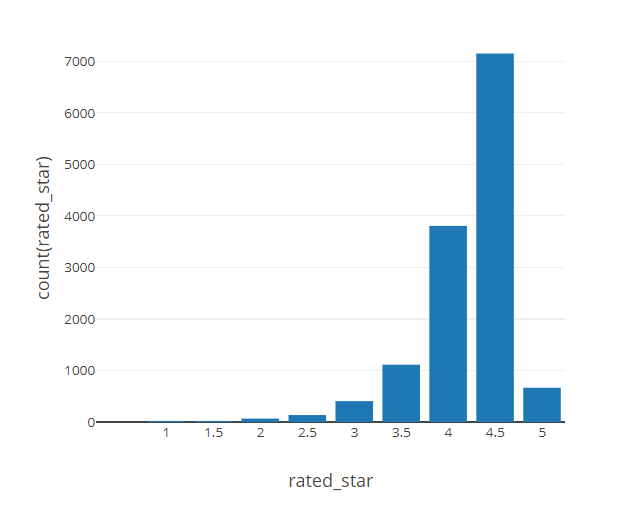

In [0]:
#Relationship between Rated Star and Total Cooking Time
df_star_cooktime = df.filter(df.rated_star > 0).groupBy("rated_star").agg({'total_time_min': 'mean'}).orderBy("rated_star")
df_star_cooktime.display()

rated_star,avg(total_time_min)
1.0,392.42857142857144
1.5,92.14285714285714
2.0,76.88372093023256
2.5,112.65116279069767
3.0,150.7404255319149
3.5,116.46184738955823
4.0,117.65138632162662
4.5,138.26445356210368
5.0,161.65297741273102


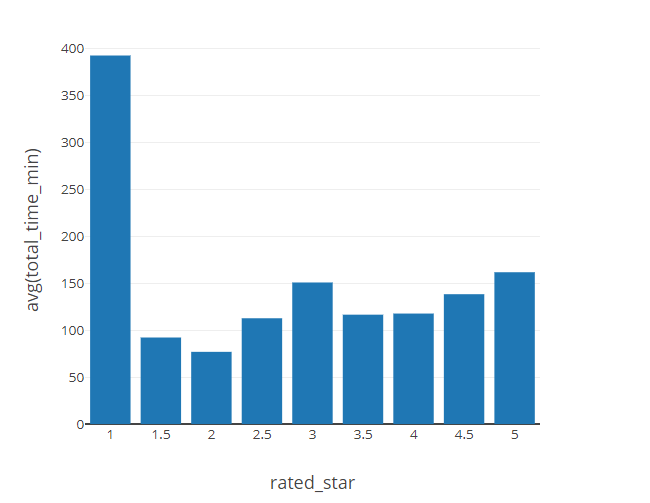

In [0]:
#Relationship between Rated Star and Number of Ingredients
df_star_ingredient = df.filter(df.rated_star > 0).groupBy("rated_star").agg({'num_ingredient': 'mean'}).orderBy("rated_star")
df_star_ingredient.display()

rated_star,avg(num_ingredient)
1.0,8.523809523809524
1.5,7.705882352941177
2.0,7.507462686567164
2.5,8.411764705882353
3.0,8.251231527093596
3.5,8.367475292003594
4.0,8.354347255056474
4.5,8.75153803131991
5.0,8.52102102102102


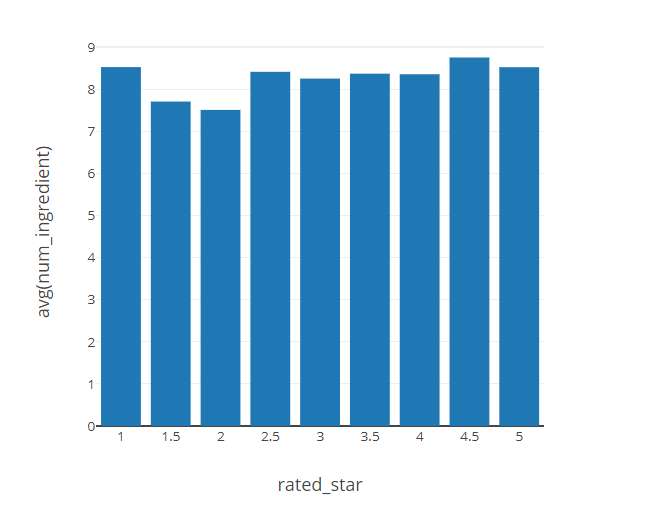

In [0]:
#Relationship between Rated Star and Number of Reviews
df_star_review = df.filter(df.rated_star > 0).groupBy("rated_star").agg({'num_review': 'mean'}).orderBy("rated_star")
df_star_review.display()

rated_star,avg(num_review)
1.0,1.8095238095238095
1.5,11.058823529411764
2.0,5.865671641791045
2.5,10.073529411764707
3.0,9.923645320197044
3.5,19.500449236298294
4.0,49.74257945889151
4.5,180.89485458612975
5.0,271.3783783783784


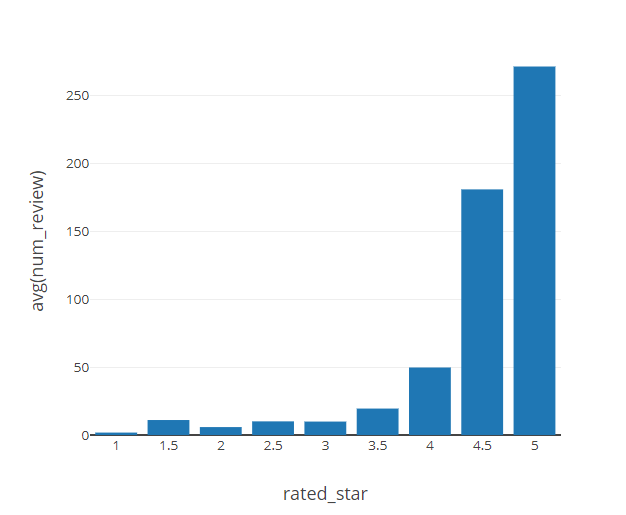

In [0]:
#Relationship between Rated Star and Number of Ratings
df_star_rating = df.filter(df.rated_star > 0).groupBy("rated_star").agg({'num_rating': 'mean'}).orderBy("rated_star")
df_star_rating.display()

rated_star,avg(num_rating)
1.0,2.0952380952380953
1.5,12.411764705882353
2.0,7.029850746268656
2.5,11.970588235294118
3.0,11.874384236453203
3.5,24.15633423180593
4.0,62.8715524034673
4.5,235.9958053691275
5.0,365.12762762762765


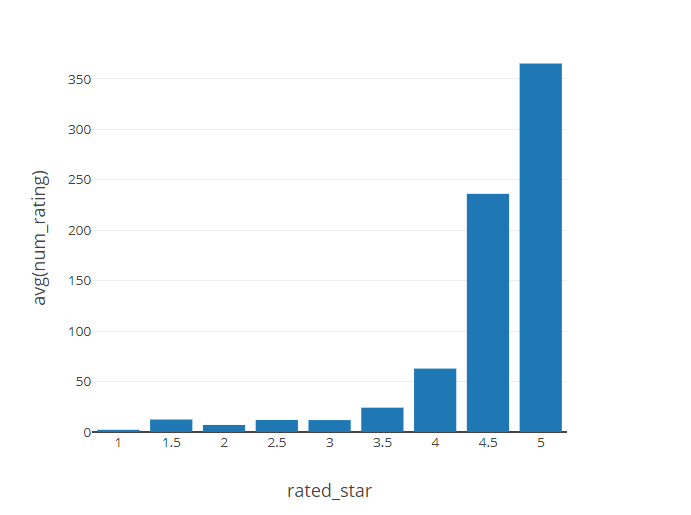

In [0]:
#Relationship between Rated Star and Fat, Protein, Carbs
df_star_nutrient_gram = df.filter(df.rated_star > 0).groupBy("rated_star").agg({'protein_gram': 'mean', 'fat_gram':'mean', 'carb_gram': 'mean' }).orderBy("rated_star")
df_star_nutrient_gram.display()

rated_star,avg(protein_gram),avg(fat_gram),avg(carb_gram)
1.0,6.57142857142857,11.476190476190474,38.93333333333333
1.5,7.458823529411765,8.817647058823532,36.252941176470586
2.0,6.970149253731344,11.316666666666666,29.746268656716424
2.5,9.773880597014925,14.715671641791046,33.08014705882353
3.0,9.906913580246911,13.688029925187044,33.79234567901234
3.5,11.273869801084995,14.348498635122846,33.036241007194256
4.0,13.21777251184835,16.48555203380878,33.62004729374672
4.5,11.786462575480954,17.633536240090606,32.63687377553882
5.0,8.013293051359511,15.75145929339478,35.037087087087066


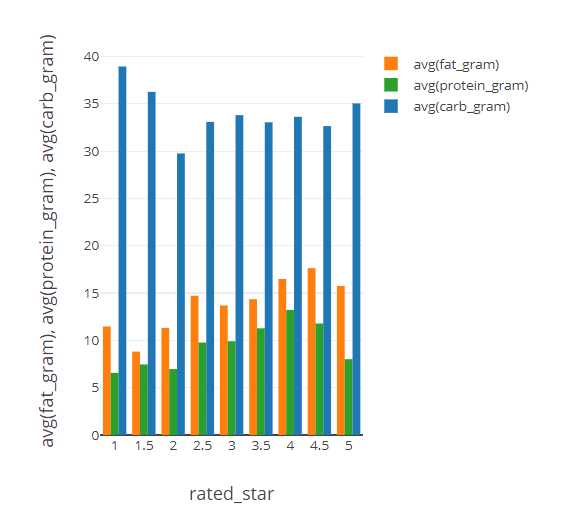

In [0]:
#Relationship between Rated Star and Cholesterol, Sodium
df_star_nutrient_milgram = df.filter(df.rated_star > 0).groupBy("rated_star").agg({'cholesterol_milligram': 'mean', 'sodium_milligram':'mean'}).orderBy("rated_star")
df_star_nutrient_milgram.display()

rated_star,avg(sodium_milligram),avg(cholesterol_milligram)
1.0,365.747619047619,29.652631578947375
1.5,611.9823529411765,35.65714285714286
2.0,284.42537313432837,47.25925925925925
2.5,376.2816176470587,67.664406779661
3.0,397.4529556650243,53.95260273972602
3.5,425.70655884995523,60.491571279916734
4.0,560.8683048620227,66.69748595090215
4.5,534.1450769230761,64.386336
5.0,316.97233082706776,51.47596491228071


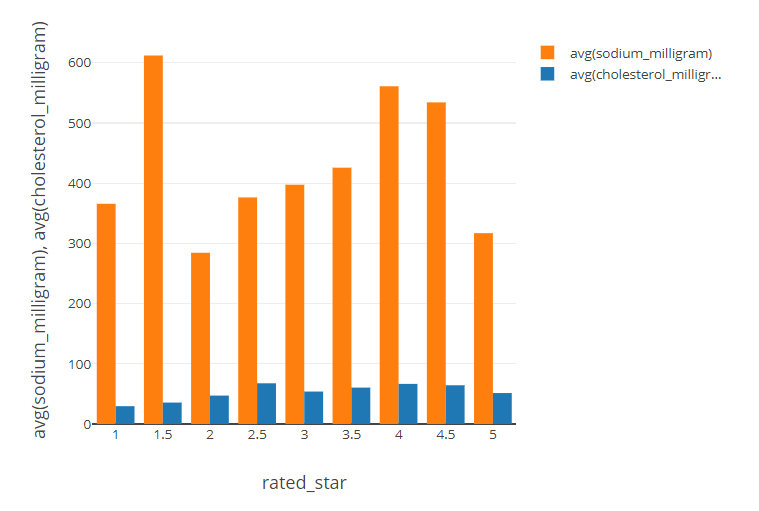

In [0]:
#Relationship between Rated Star and Calories
df_star_calorie = df.filter(df.rated_star > 0).groupBy("rated_star").agg({'calorie': 'mean'}).orderBy("rated_star")
df_star_calorie.display()

rated_star,avg(calorie)
1.0,299.5238095238095
1.5,252.05882352941177
2.0,250.56716417910448
2.5,299.05882352941177
3.0,296.4950738916256
3.5,304.2659478885894
4.0,333.58628841607566
4.5,332.5257270693512
5.0,313.84684684684686


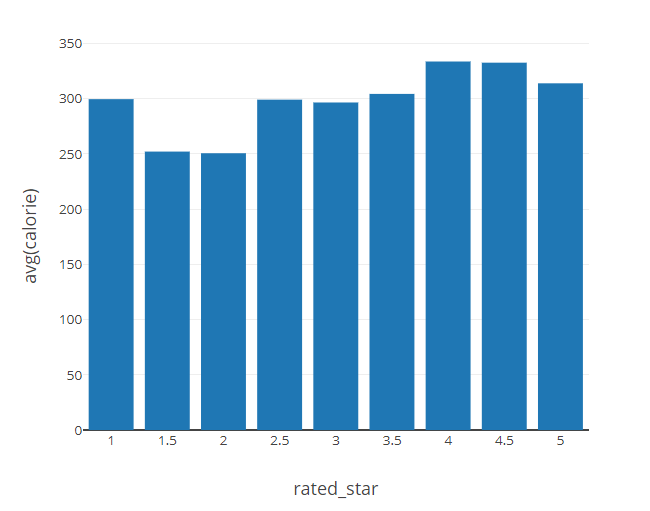

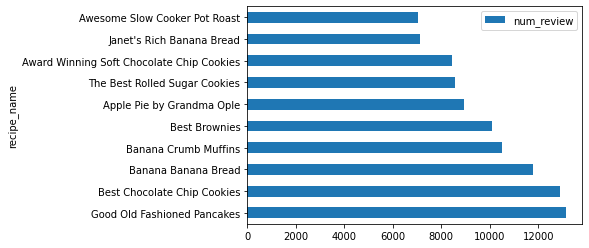

In [0]:
#Top 10 recipes with the most reviews (using pyplot)
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

#isinstance(df, pd.DataFrame) #currently displaying False, requires line below
df = df.toPandas() #requires running only once to change to pandas dataframe

top_num_review = df.nlargest(10, 'num_review')[['recipe_name','num_review']]
ax_num_review = top_num_review.plot.barh(x='recipe_name', y='num_review')

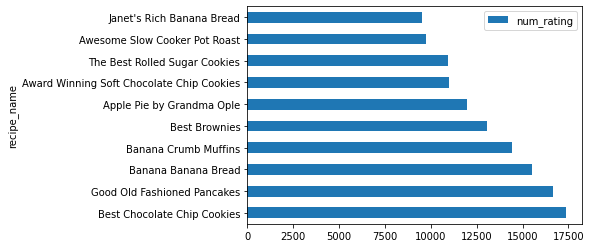

In [0]:
#top 10 recipes with the most number of ratings (using pyplot)
top_num_rating = df.nlargest(10, 'num_rating')[['recipe_name','num_rating']]
ax_num_rating = top_num_rating.plot.barh(x='recipe_name', y='num_rating')

Out[67]: <AxesSubplot:>

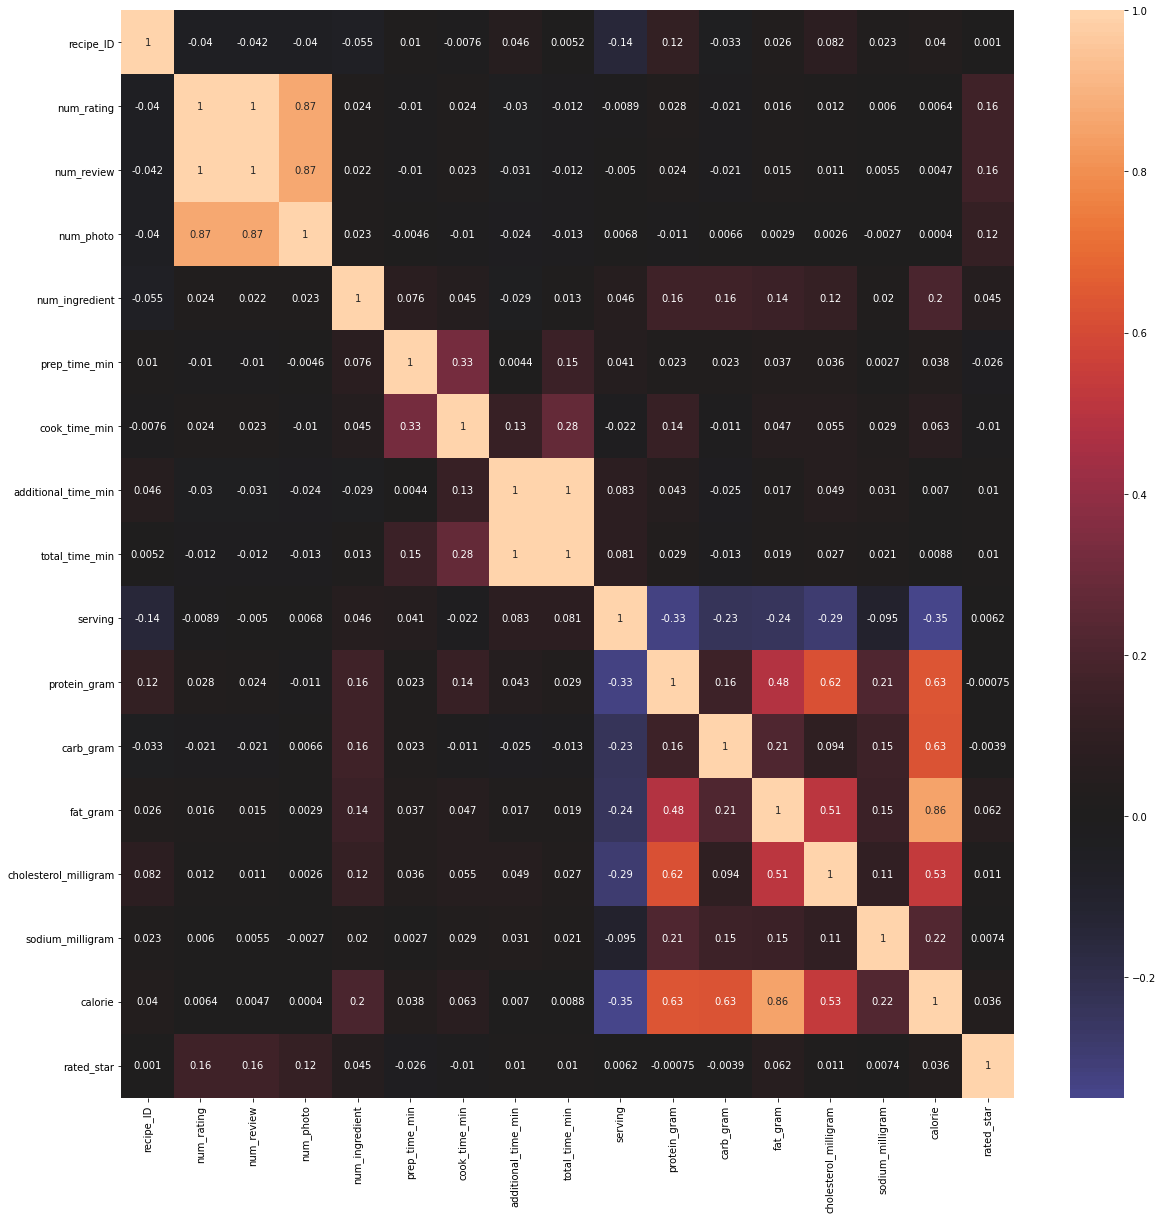

In [0]:
#Correlation plot between variables
corrmat= df.corr()
plt.figure(figsize=(20,20))  
sns.heatmap(corrmat,annot=True, center=0)